# Synthesising Datasets
In this notebook, we combine the **cleaned** datasets that came from other analysis. Geometry needs to be added back into the datasets.

* Inside Airbnb Datasets
* LSOA & Deprivation
* Evictions

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
# adding the borough data for maps
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


Here, 

In [4]:
lsoa_shp_file = gpd.read_file('LSOA & Dep Data/ESRI/LSOA_2011_London_gen_MHW.shp')

#### Read in 2022 Airbnb Data

In [5]:
#Note, this does not include the geometry because that is not preserved when something is read as a feather. Further, this only includes the fields we are interested in. For the cleaned dataset with all of the fields clean, go to the Airbnb2022_Final.ipynb
listings2022 = pd.read_feather('listings22')

<u>The following Datasets have been Filtered by Terms associated with Gentrification<u>

In [6]:
listings2022_gentrification = pd.read_feather('listings22_gentrification')

In [7]:
listings2022_kensington_chelsea = pd.read_feather('listings22_kensington_chelsea')

In [8]:
listings2022_camden = pd.read_feather('listings22_camden')

In [9]:
listings2022_hackney = pd.read_feather('listings22_hackney')

#### Read in 2019 Airbnb Data

#### Read in Eviction Data

In [10]:
evict2019 = pd.read_csv('2019_evictions_geom')

In [11]:
evict2022 = pd.read_csv('2022_evictions_geom')

#### Read in LSOA & IMD Data
This data is for each borough that we are targetting but broken down into LSOAs so we can get a more micro level view of deprivation there.

In [12]:
hackney_dep = pd.read_csv('LSOA & Dep Data/hackLSOA_dep')

In [13]:
camden_dep = pd.read_csv('LSOA & Dep Data/CamdenLSOA_dep')

In [14]:
kc_dep = pd.read_csv('LSOA & Dep Data/kcLSOA_dep')

In [15]:
London_dep = pd.read_csv('LSOA & Dep Data/London_dep')

In [16]:
London_dep.columns.tolist()

['Unnamed: 0',
 'LSOA11CD',
 'LSOA11NM',
 'geometry',
 'LSOA code (2011)',
 'Local Authority District code (2019)',
 'LAD',
 'Barriers to Housing and Services Score',
 'Barriers to Housing and Services Rank (where 1 is most deprived)',
 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)',
 'transformed_mms']

In [17]:
London_borough_dep = London_dep.groupby('LAD')['Barriers to Housing and Services Score'].agg('mean')

In [18]:
London_borough_dep.info(verbose=True)

<class 'pandas.core.series.Series'>
Index: 33 entries, Barking and Dagenham to Westminster
Series name: Barriers to Housing and Services Score
Non-Null Count  Dtype  
--------------  -----  
33 non-null     float64
dtypes: float64(1)
memory usage: 528.0+ bytes


### Merging 2022 Airbnb Data: All London

In [19]:
airbnb_merged1 = pd.merge(listings2022, evict2022, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='Area', suffixes=('neighbourhood_cleansed', 'Area'))

In [20]:
airbnb_merged2 = pd.merge(airbnb_merged1, London_borough_dep, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='LAD', suffixes=('neighbourhood_cleansed', 'Area'))

In [21]:
airbnb_merged2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69054 entries, 0 to 69053
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69054 non-null  int64   
 1   name                                    69034 non-null  object  
 2   description                             67827 non-null  object  
 3   host_id                                 69054 non-null  int64   
 4   host_location                           56983 non-null  category
 5   host_listings_count                     69054 non-null  UInt16  
 6   host_total_listings_count               69054 non-null  UInt16  
 7   neighbourhood_cleansed                  69054 non-null  object  
 8   latitude                                69054 non-null  float64 
 9   longitude                               69054 non-null  float64 
 10  property_type                           69054 

In [22]:
airbnb_merged2.sample(5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometryArea,area,density,Standardised Evictions,Barriers to Housing and Services Score
65018,19688000,3 Bedr riverside apartment North Greenwich 090,This beautiful modern three bedroom apartment ...,1409439,"London, United Kingdom",27,75,Greenwich,51.50,0.01,...,Greenwich,E09000011,"5,044.19",310.79,F,"MULTIPOLYGON (((537238.7 178137.7, 537242.6 17...","47,334,072.53",0.15,1.00,32.11
2493,38202811,Islington roof garden flat,"Hello,<br />The flat is much loved and lived i...",44011905,"England, United Kingdom",2,4,Islington,51.55,-0.11,...,Islington,E09000019,"1,485.66",0.00,T,"MULTIPOLYGON (((529153.6 185861.4, 529144.8 18...","14,856,652.55",NaN,NaN,28.00
30217,581232071517825536,3 bedroom house in Parsons Green,Three bedroom family home in Fulham. The house...,3729906,"London, United Kingdom",1,4,Hammersmith and Fulham,51.48,-0.21,...,Hammersmith and Fulham,E09000013,"1,715.41",75.65,T,"MULTIPOLYGON (((521975.8 178100, 521973 178109...","16,397,617.54",NaN,NaN,28.11
19277,53410932,"Private MODERN Studio Central London, Zone 1, W1.",A Stylish & Modern studio flat in Central Lond...,392279502,"London, United Kingdom",14,18,Westminster,51.52,-0.16,...,Westminster,E09000033,"2,203.01",54.31,T,"MULTIPOLYGON (((528549.5 177903.8, 528542.6 17...","21,486,976.77",0.14,-0.33,23.20
40064,683169543464479744,Double Bedroom KX - Your Place in Central London,"Stay in Central London, where you can have acc...",457104205,NaN,6,6,Camden,51.53,-0.12,...,Camden,E09000007,"2,178.93",0.00,T,"MULTIPOLYGON (((528840.2 187217.8, 528834.6 18...","21,789,295.89",0.14,-0.33,21.55


In [23]:
airbnb_merged2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69054 entries, 0 to 69053
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69054 non-null  int64   
 1   name                                    69034 non-null  object  
 2   description                             67827 non-null  object  
 3   host_id                                 69054 non-null  int64   
 4   host_location                           56983 non-null  category
 5   host_listings_count                     69054 non-null  UInt16  
 6   host_total_listings_count               69054 non-null  UInt16  
 7   neighbourhood_cleansed                  69054 non-null  object  
 8   latitude                                69054 non-null  float64 
 9   longitude                               69054 non-null  float64 
 10  property_type                           69054 

In [24]:
airbnb_merged2 = gpd.GeoDataFrame(airbnb_merged2, geometry=gpd.points_from_xy(airbnb_merged2.longitude, airbnb_merged2.latitude))
airbnb_merged2.crs = {'init': 'epsg:4326'}
airbnb_merged2 = airbnb_merged2.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
airbnb_merged2.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [26]:
print(type(airbnb_merged2.geometry))

<class 'geopandas.geoseries.GeoSeries'>


In [52]:
airbnb_merged2.shape

(5713, 31)

In [28]:
airbnb_merged2.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69054 entries, 0 to 69053
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69054 non-null  int64   
 1   name                                    69034 non-null  object  
 2   description                             67827 non-null  object  
 3   host_id                                 69054 non-null  int64   
 4   host_location                           56983 non-null  category
 5   host_listings_count                     69054 non-null  UInt16  
 6   host_total_listings_count               69054 non-null  UInt16  
 7   neighbourhood_cleansed                  69054 non-null  object  
 8   latitude                                69054 non-null  float64 
 9   longitude                               69054 non-null  float64 
 10  property_type                         

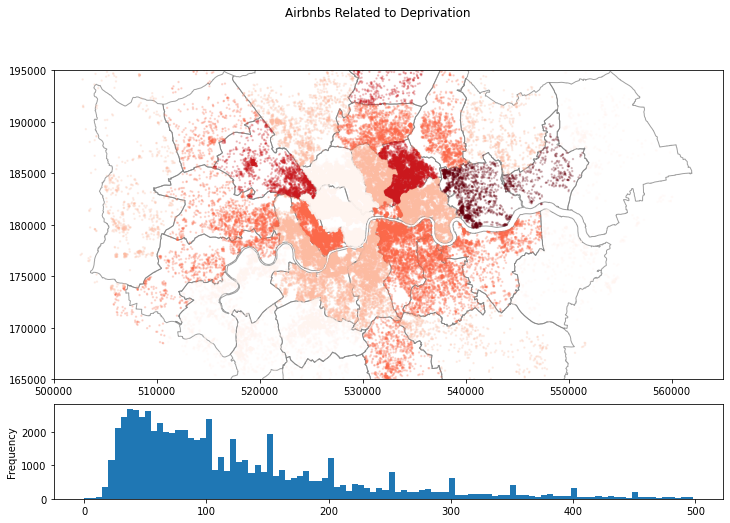

In [29]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
airbnb_merged2[airbnb_merged2.price<airbnb_merged2.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Airbnbs Related to Deprivation")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Merging 2022 Airbnb Data & LSOA: Gentrification Regex

In [30]:
airbnb_merged1 = pd.merge(listings2022_gentrification, evict2022, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='Area', suffixes=('neighbourhood_cleansed', 'Area'))

In [31]:
airbnb_merged2 = pd.merge(airbnb_merged1, London_borough_dep, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='LAD', suffixes=('neighbourhood_cleansed', 'Area'))

In [32]:
airbnb_merged2 = gpd.GeoDataFrame(airbnb_merged2, geometry=gpd.points_from_xy(airbnb_merged2.longitude, airbnb_merged2.latitude))
airbnb_merged2.crs = {'init': 'epsg:4326'}
airbnb_merged2 = airbnb_merged2.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [33]:
airbnb_merged2.sample(5, random_state=42)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometryArea,area,density,Standardised Evictions,Barriers to Housing and Services Score,geometry
1700,11732568,Friendly room in trendy Haggerston,The room is a perfect spot for a weekend or mi...,43661091,"London, United Kingdom",1,2,Hackney,51.54,-0.08,...,E09000012,"1,904.90",0.00,T,"MULTIPOLYGON (((531928.4 187801.5, 531935.7 18...","19,049,027.67",NaN,NaN,42.66,POINT (533406.061 183909.491)
3269,49259438,"PRIME LOCATION, BRIGHT AND CLEAN SINGLE ROOM.","Bright, single bedroom located 10 minutes walk...",328039974,"England, United Kingdom",1,2,Westminster,51.51,-0.13,...,E09000033,"2,203.01",54.31,T,"MULTIPOLYGON (((528549.5 177903.8, 528542.6 17...","21,486,976.77",0.14,-0.33,23.20,POINT (530062.126 180269.672)
561,48115315,The Liverpool Street Collection,Please Note: We are a London based specialist ...,269308503,"London, United Kingdom",79,86,Tower Hamlets,51.52,-0.08,...,E09000030,"2,157.50",179.71,T,"MULTIPOLYGON (((533387.6 180516.4, 533389.8 18...","19,777,936.92",0.10,-0.67,30.32,POINT (533532.082 181580.327)
5466,42081823,Locke at Broken Wharf River Suite,Choose a River Suite for uninterrupted views o...,333684904,NaN,7,7,City of London,51.51,-0.10,...,E09000001,314.94,24.55,T,"MULTIPOLYGON (((531145.1 180782.1, 531143.8 18...","2,903,925.63",NaN,NaN,36.27,POINT (532280.086 180858.816)
5280,17786350,"New, clean and bright bedroom with Queensize bed.","Medium size, modern, clean and bright room. Wi...",108160366,"London, United Kingdom",1,2,Waltham Forest,51.59,-0.02,...,E09000031,"3,880.79",0.00,F,"MULTIPOLYGON (((539923.1 191863.1, 539928.1 19...","38,807,965.33",0.18,1.00,36.25,POINT (537277.597 189374.369)


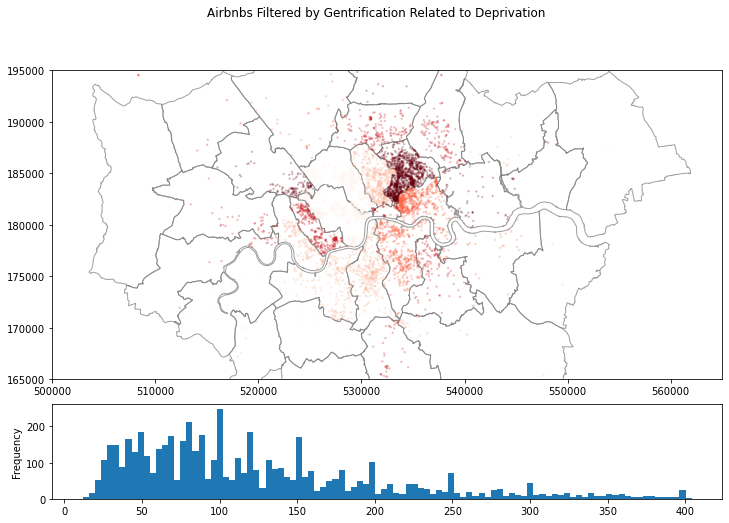

In [34]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
airbnb_merged2[airbnb_merged2.price<airbnb_merged2.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Airbnbs Filtered by Gentrification Related to Deprivation")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Merging 2022 Airbnb Data & LSOA: Kensington and Chelsea

In [35]:
listings2022_kensington_chelsea = gpd.GeoDataFrame(listings2022_kensington_chelsea, geometry=gpd.points_from_xy(listings2022_kensington_chelsea.longitude, listings2022_kensington_chelsea.latitude))
listings2022_kensington_chelsea.crs = {'init': 'epsg:4326'}
listings2022_kensington_chelsea = listings2022_kensington_chelsea.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [36]:
print(type(listings2022_kensington_chelsea.geometry))

<class 'geopandas.geoseries.GeoSeries'>


In [37]:
listings2022_kensington_chelsea.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [38]:
listings2022_kensington_chelsea.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4596 entries, 1 to 69326
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         4596 non-null   int64   
 1   name                       4596 non-null   object  
 2   description                4535 non-null   object  
 3   host_id                    4596 non-null   int64   
 4   host_location              3718 non-null   category
 5   host_listings_count        4596 non-null   UInt16  
 6   host_total_listings_count  4596 non-null   UInt16  
 7   neighbourhood_cleansed     4596 non-null   category
 8   latitude                   4596 non-null   float64 
 9   longitude                  4596 non-null   float64 
 10  property_type              4596 non-null   category
 11  room_type                  4596 non-null   category
 12  price                      4596 non-null   float64 
 13  minimum_nights          

In [39]:
lsoa_shp_file.columns.tolist()

['LSOA11CD',
 'LSOA11NM',
 'MSOA11CD',
 'MSOA11NM',
 'LAD11CD',
 'LAD11NM',
 'RGN11CD',
 'RGN11NM',
 'USUALRES',
 'HHOLDRES',
 'COMESTRES',
 'POPDEN',
 'HHOLDS',
 'AVHHOLDSZ',
 'geometry']

In [40]:
kc_dep.columns.tolist()

['Unnamed: 0',
 'LSOA11CD',
 'LSOA11NM',
 'geometry',
 'LSOA code (2011)',
 'Local Authority District code (2019)',
 'LAD',
 'Barriers to Housing and Services Score',
 'Barriers to Housing and Services Rank (where 1 is most deprived)',
 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)',
 'transformed_mms']

In [41]:
kc_dep2 = lsoa_shp_file.merge(kc_dep, how="inner", left_on='LSOA11CD', right_on='LSOA11CD')


In [42]:
kc_dep2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 25 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         103 non-null    object  
 1   LSOA11NM_x                                                                       103 non-null    object  
 2   MSOA11CD                                                                         103 non-null    object  
 3   MSOA11NM                                                                         103 non-null    object  
 4   LAD11CD                                                                          103 non-null    object  
 5   LAD11NM                                                                          103 non-null    object  
 6   RG

In [43]:
kc_dep3 = gpd.GeoDataFrame(kc_dep2, geometry='geometry_x')
kc_dep3.crs = {'init': 'epsg:4326'}
kc_dep3 = kc_dep3.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [44]:
print(type(kc_dep3.geometry))

<class 'geopandas.geoseries.GeoSeries'>


In [45]:
kc_dep3.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 25 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         103 non-null    object  
 1   LSOA11NM_x                                                                       103 non-null    object  
 2   MSOA11CD                                                                         103 non-null    object  
 3   MSOA11NM                                                                         103 non-null    object  
 4   LAD11CD                                                                          103 non-null    object  
 5   LAD11NM                                                                          103 non-null    object  

In [46]:
listings2022_kensington_chelsea.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,Kensington and Chelsea,51.49,-0.17,Entire rental unit,Entire home/apt,75.00,3,50,POINT (527284.576 178129.679)
7,284603,Notting Hill church stay in Heaven!,<b>The space</b><br />Overview:<br /><br />Loc...,1481851,"London, United Kingdom",1,2,Kensington and Chelsea,51.51,-0.20,Entire rental unit,Entire home/apt,297.00,14,365,POINT (524995.812 181059.452)
60,165336,Charming Flat in Notting Hill,A stylish apartment close to Portobello market...,761400,"London, United Kingdom",1,1,Kensington and Chelsea,51.52,-0.21,Entire rental unit,Entire home/apt,100.00,1,14,POINT (524244.638 181342.578)


In [47]:
kc_dep3.head(n=2)

,LSOA11CD,LSOA11NM_x,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Unnamed: 0,LSOA11NM_y,geometry_y,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,E01002812,Kensington and Chelsea 013A,E02000589,Kensington and Chelsea 013,E09000020,Kensington and Chelsea,E12000007,London,1917,1763,...,2747,Kensington and Chelsea 013A,"POLYGON ((525802.22499993 179074.02600009655, ...",E01002812,E09000020,Kensington and Chelsea,40.75,1981,1,0.53
1,E01002813,Kensington and Chelsea 011A,E02000587,Kensington and Chelsea 011,E09000020,Kensington and Chelsea,E12000007,London,1767,1767,...,2748,Kensington and Chelsea 011A,"POLYGON ((525387.795999887 179246.17700007392,...",E01002813,E09000020,Kensington and Chelsea,27.38,8934,3,0.32


In [67]:
print(kc_dep3.crs)
#print(listings2022_kensington_chelsea)

epsg:27700


In [65]:
polygon_df = kc_dep3.set_crs(kc_dep3.crs,allow_override=True).to_crs("EPSG:27700")

listings2022_kensington_chelsea.to_crs(epsg=27700)
#kc_dep3.to_crs(epsg=27700)

new_df = gpd.sjoin(listings2022_kensington_chelsea, polygon_df, how = 'inner', 
                  predicate = 'within')

new_df

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,Unnamed: 0,LSOA11NM_y,geometry_y,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms


/opt/conda/lib/python3.10/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)
/opt/conda/lib/python3.10/site-packages/pygeos/predicates.py:906: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


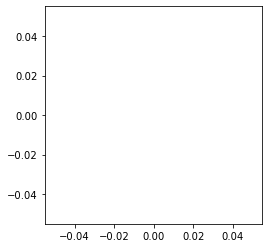

In [59]:
# Create a boolean mask indicating which points fall within the polygons
mask = listings2022_kensington_chelsea.geometry.within(kc_dep3.geometry_x.unary_union)

# Subset the point data to only include points within the polygons
points_within_polygons = listings2022_kensington_chelsea.geometry.loc[mask]

# Create the map figure and axis
fig, ax = plt.subplots()

# Plot the polygons on the map
kc_dep3.geometry_x.plot(ax=ax, color='white', edgecolor='black')

# Plot the point data on top of the polygons
points_within_polygons.plot(ax=ax, markersize=5, color='red')

# Show the map
plt.show()

In [49]:
points_within_polygons = gpd.sjoin(listings2022_kensington_chelsea, kc_dep3, predicate='within')

In [50]:
points_within_polygons.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,Unnamed: 0,LSOA11NM_y,geometry_y,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms


In [ ]:
kc_merged.head(n=3)

In [ ]:
# kc_merged = gpd.sjoin(listings2022_kensington_chelsea, kc_dep, how='inner', predicate='within', 
#                       left_on='geometry', right_on='geometry')

In [ ]:
kc_merged = kc_merged.set_geometry('geometry_x')
kc_merged.plot(column='Barriers to Housing and Services Score', legend=True, figsize=(8,8), scheme='user_defined', classification_kwds={'bins':[5,10,15,20,25,30,35,40,45,50,55,60,65,70]},cmap = 'Reds');

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
kc_merged.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

# ax1.set_xlim([500000, 565000])
# ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
# ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
# kc_merged[kc_merged.price<kc_merged.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Merging 2022 Airbnb Data: Camden

### Merging 2022 Airbnb Data: Hackney

In [19]:
listings2022_hackney = gpd.GeoDataFrame(listings2022_hackney, geometry=gpd.points_from_xy(listings2022_hackney.longitude, listings2022_hackney.latitude))
listings2022_hackney.crs = {'init': 'epsg:4326'}
listings2022_hackney = listings2022_hackney.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [95]:
listings2022_hackney.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5164 entries, 28 to 68567
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         5164 non-null   int64   
 1   name                       5162 non-null   object  
 2   description                5098 non-null   object  
 3   host_id                    5164 non-null   int64   
 4   host_location              4647 non-null   category
 5   host_listings_count        5164 non-null   UInt16  
 6   host_total_listings_count  5164 non-null   UInt16  
 7   neighbourhood_cleansed     5164 non-null   category
 8   latitude                   5164 non-null   float64 
 9   longitude                  5164 non-null   float64 
 10  property_type              5164 non-null   category
 11  room_type                  5164 non-null   category
 12  price                      5164 non-null   float64 
 13  minimum_nights         

In [22]:
hackney_dep = lsoa_shp_file.merge(hackney_dep, how="inner", left_on='LSOA11CD', right_on='LSOA11CD')

In [79]:
hackney_dep.head(5)

,LSOA11CD,LSOA11NM_x,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Unnamed: 0,LSOA11NM_y,geometry_y,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,E01001714,Hackney 002A,E02000346,Hackney 002,E09000012,Hackney,E12000007,London,1490,1468,...,1676,Hackney 002A,POLYGON ((532084.8620000243 187425.27800004705...,E01001714,E09000012,Hackney,45.51,968,1,0.61
1,E01001715,Hackney 007A,E02000351,Hackney 007,E09000012,Hackney,E12000007,London,1321,1316,...,1677,Hackney 007A,POLYGON ((531971.5360000525 187248.00699991966...,E01001715,E09000012,Hackney,46.81,746,1,0.63
2,E01001716,Hackney 007B,E02000351,Hackney 007,E09000012,Hackney,E12000007,London,1318,1260,...,1678,Hackney 007B,"POLYGON ((531916.380000002 187056.60500008028,...",E01001716,E09000012,Hackney,47.81,590,1,0.64
3,E01001717,Hackney 007C,E02000351,Hackney 007,E09000012,Hackney,E12000007,London,1222,1222,...,1679,Hackney 007C,POLYGON ((532205.0979999949 187016.36199987744...,E01001717,E09000012,Hackney,47.27,666,1,0.64
4,E01001718,Hackney 007D,E02000351,Hackney 007,E09000012,Hackney,E12000007,London,1787,1787,...,1680,Hackney 007D,POLYGON ((531727.2930000254 186813.98100011528...,E01001718,E09000012,Hackney,39.69,2290,1,0.52


In [23]:
hackney_dep.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 25 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         144 non-null    object  
 1   LSOA11NM_x                                                                       144 non-null    object  
 2   MSOA11CD                                                                         144 non-null    object  
 3   MSOA11NM                                                                         144 non-null    object  
 4   LAD11CD                                                                          144 non-null    object  
 5   LAD11NM                                                                          144 non-null    object  
 6   RG

In [85]:
to_drop = ['LSOA11NM_x', 'MSOA11CD','MSOA11NM','LAD11CD','LAD11NM','RGN11CD','RGN11NM',
 'USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','geometry_y','Unnamed: 0', 'LSOA11NM_y']
hackney_dep2 = hackney_dep.drop(axis=1, columns=to_drop)
#transformed mms comes from the eviction dataset where I used min-max scaler to standardise the eviction data

In [86]:
hackney_dep2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 9 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         144 non-null    object  
 1   geometry_x                                                                       144 non-null    geometry
 2   LSOA code (2011)                                                                 144 non-null    object  
 3   Local Authority District code (2019)                                             144 non-null    object  
 4   LAD                                                                              144 non-null    object  
 5   Barriers to Housing and Services Score                                           144 non-null    float64 
 6   Bar

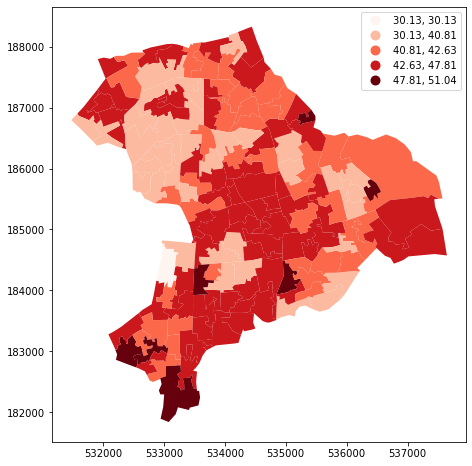

In [112]:
Hackg = hackney_dep2.set_geometry('geometry_x')
Hackg.plot(column='Barriers to Housing and Services Score', legend=True, 
             figsize=(8,8), scheme='Fisher_Jenks_Sampled',cmap = 'Reds');

In [149]:
hack_list = listings2022_hackney.merge(hackney_dep2, how="left", left_on='neighbourhood_cleansed', right_on='LAD')

In [150]:
hack_list2 = hack_list.groupby('LSOA11CD').agg({'id': 'first','name': 'first','description': 'first','host_id': 'first','host_location': 'first','host_listings_count': 'first','host_total_listings_count': 'first','neighbourhood_cleansed': 'first','latitude': 'first','longitude': 'first','property_type': 'first','room_type': 'first','price': 'first','minimum_nights': 'first','maximum_nights': 'first','geometry': 'first','geometry_x': 'first','LSOA code (2011)': 'first','Local Authority District code (2019)': 'first','LAD': 'first','Barriers to Housing and Services Score': 'mean','Barriers to Housing and Services Rank (where 1 is most deprived)': 'first','Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)': 'first','transformed_mms': 'first'})

In [151]:
hack_list2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, E01001714 to E01033713
Data columns (total 24 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   id                                                                               144 non-null    int64   
 1   name                                                                             144 non-null    object  
 2   description                                                                      144 non-null    object  
 3   host_id                                                                          144 non-null    int64   
 4   host_location                                                                    144 non-null    category
 5   host_listings_count                                                              144 non-null    UInt16 

In [152]:
hack_list2 = gpd.GeoDataFrame(hack_list2, geometry=gpd.points_from_xy(hack_list2.longitude, hack_list2.latitude))
hack_list2.crs = {'init': 'epsg:4326'}
hack_list2 = hack_list2.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [153]:
hack_list2.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 144 entries, E01001714 to E01033713
Data columns (total 24 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   id                                                                               144 non-null    int64   
 1   name                                                                             144 non-null    object  
 2   description                                                                      144 non-null    object  
 3   host_id                                                                          144 non-null    int64   
 4   host_location                                                                    144 non-null    category
 5   host_listings_count                                                              144 non-null   

In [154]:
# hackg.info(verbose=True)

In [121]:
hackg_mean = hackg.groupby('LSOA11CD').agg({'geometry_x': 'first', 'LSOA code (2011)': 'first', 'Local Authority District code (2019)': 'first','LAD': 'first','Barriers to Housing and Services Score': 'mean','Barriers to Housing and Services Rank (where 1 is most deprived)': 'first'
                                            ,'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)': 'first','transformed_mms': 'first'})

In [127]:
hackg_mean = hackg_mean.set_geometry('geometry_x')
hackg_mean = hackg_mean.set_crs(epsg=27700, allow_override=True)

# THIS IS THE KEY TO THE CODE: maybe lol

In [96]:
# hackg['buffered'] = hackg.geometry_x.buffer(250)
# hackg = hackg.set_geometry('buffered').set_crs(epsg=27700)

In [106]:
# # hack_merged = gpd.sjoin(hackg, listings2022_hackney, op="within")
# intersection_df = gpd.overlay(hackg, listings2022_hackney, how='intersection')

/tmp/ipykernel_161/597705312.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 28698 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_df = gpd.overlay(hackg, listings2022_hackney, how='intersection')


In [115]:
# from shapely.ops import snap

# # Perform the snap operation on the intersection points
# hack_merged['geometry_new'] = hack_merged2.apply(lambda x: snap(x.geometry,
#                                                                    listings2022_hackney.unary_union, tolerance=0.1), axis=1)

In [145]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

norm = Normalize(vmin=hack_list2['Barriers to Housing and Services Score'].min(), 
                 vmax=hack_list2['Barriers to Housing and Services Score'].max())

colormap = ScalarMappable(norm=norm, cmap='cool')

ax.scatter(x=listings2022_hackney.geometry.x, y=listings2022_hackney.geometry.y, c=colormap.to_rgba(hack_list2['Barriers to Housing and Services Score']), s=5)


ValueError: 'c' argument has 144 elements, which is inconsistent with 'x' and 'y' with size 5164.

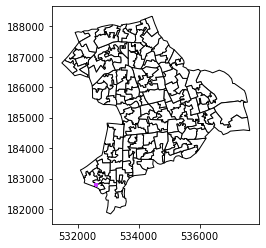

In [155]:
# Create the map figure and axis
fig, ax = plt.subplots()

# Plot the polygons on the map
hackg_mean.plot(ax=ax, color='white', edgecolor='black')

# Plot the points on top of the polygons
ax.scatter(x=hack_list2.geometry.x, y=hack_list2.geometry.y, c=hack_list2['Barriers to Housing and Services Score'], cmap='cool', s=5)

plt.show()

In [75]:
hack_merged.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28698 entries, 0 to 138
Data columns (total 43 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         28698 non-null  object  
 1   LSOA11NM_x                                                                       28698 non-null  object  
 2   MSOA11CD                                                                         28698 non-null  object  
 3   MSOA11NM                                                                         28698 non-null  object  
 4   LAD11CD                                                                          28698 non-null  object  
 5   LAD11NM                                                                          28698 non-null  object

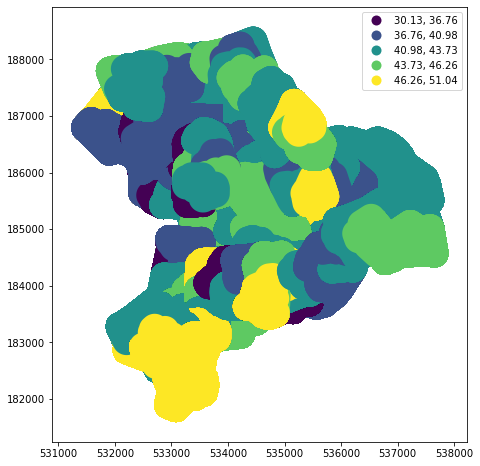

In [77]:
hack_merged.plot(column='Barriers to Housing and Services Score', legend=True, 
             figsize=(8,8), scheme='Fisher_Jenks_Sampled',cmap = 'viridis');

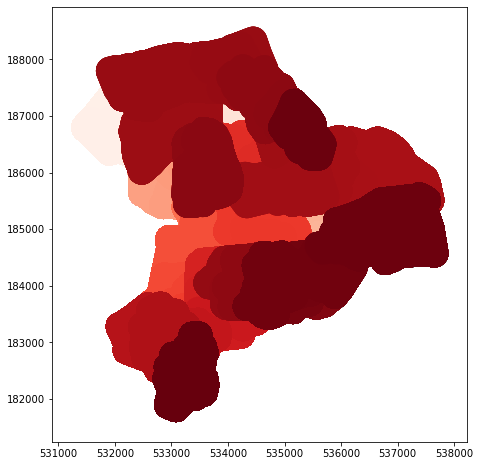

In [54]:
hack_merged.plot(markersize=0.01, legend=True, 
             figsize=(8,8), scheme='Fisher_Jenks_Sampled',cmap = 'Reds');

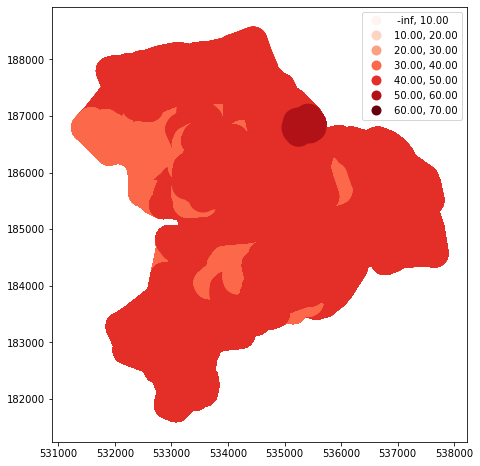

In [52]:
hack_merged.plot(markersize=1,column='Barriers to Housing and Services Score', legend=True, 
             figsize=(8,8), scheme='user_defined', classification_kwds={'bins':[10,20,30,40,50,60,70]},cmap = 'Reds');

In [47]:
#they merged I think but now gotta map